# Open Pit Mine Production Scheduling with Clusters (OPMPS-C) and Degree Uncertainty

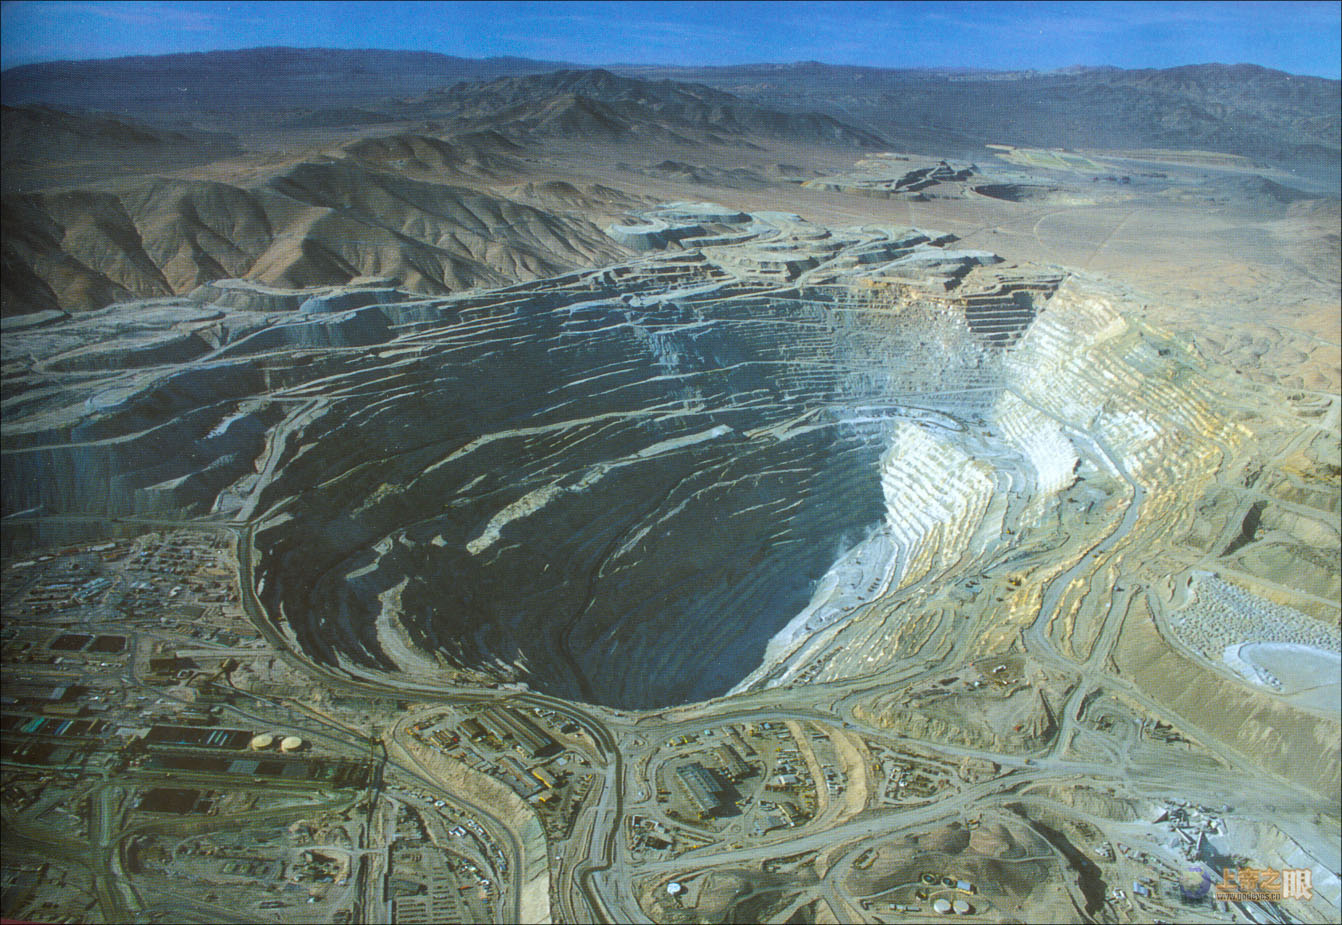

# Set parameters

In [1]:
#import(Pkg);Pkg.clone("https://github.com/tomaslg/TBSIM.jl.git")
using TBSIM,LinearAlgebra,Distributions,JuMP,Gurobi
env = Gurobi.Env()
mastersolver = GurobiSolver(env,OutputFlag=0,Threads=1,PreCrush=1, Cuts=0, Presolve=0, Heuristics=0.0)

Captotalextraccion = 1.066e5
Captotalproceso1 = [Captotalextraccion/2,23725076236.0]

Nξ=2
Ξ=1:Nξ

bkl,x=  tbsim_cubic(1,39,39,6,5.,5.,5.,10.,10.,10.)
dhl,xdh=tbsim_cubic(1,19,19,3,0.,0.,5.,20.,20.,10.)

lws=tbsim_cubic(Nξ,vcat(xdh,x))

DH=lws[1:length(dhl),:]
ξ=lws[(length(dhl)+1):(length(dhl)+length(bkl)),:]

cff=10;crf=0.25;cm=2.5;recovery=0.85;copperprice=2.1;tonpound=2204.62;
function linearTprc(lawscc,Ω,blockcluster,NoEscenarios,bci)
    scenarioslaws=zeros(length(Ω),2*NoEscenarios)
    for ξ =1:NoEscenarios
        for i in bci
            scenarioslaws[i,2*ξ - 1] =  round(-cm*Ω[i],digits=6)
            scenarioslaws[i,2*ξ] = round((max(lawscc[i,ξ],0.)*tonpound*(copperprice-crf)*recovery - cff -cm)*Ω[i],digits=6)
        end
    end
    return scenarioslaws
end
function setxdict(xdict,x,𝝹,T)
  for ccc=1:𝝹
    for ttt=1:T
      xdict[(ccc,ttt)]=x[ccc,ttt];
    end
  end
end


Academic license - for non-commercial use only


setxdict (generic function with 1 method)

In [2]:
println("len(lws)=",length(lws));
println("len(DH)=",length(DH));
println("len(ξ)=",length(ξ));

len(lws)=20418
len(DH)=2166
len(ξ)=18252


$$ \max_{s.t.}{ \sum_{c\in C,t\in T} P_{c,t} x_{c,t} + \sum_{t\in T,b\in B, \xi \in \Xi}} P_{b,t}^{\xi} y_{b,t}^{\xi} $$
$$ \sum_{t \in T} x_{c,t}  \leq 1$$
$$  y_{b,t}^ξ \leq x_{c,t} , \; \forall c \in C, b \in c, t \in T $$
$$ \sum_{s=1}^t x_{c_1,s} \geq \sum_{s=1}^t x_{c_2,s}, \; \forall (c_1,c_2) \in E, t \in T $$
$$ \sum_{c \in C} x_{c,t} \Omega ext_c  \leq K^{ex}, \; \forall t \in T $$
$$ \sum_{b \in B} y_{b,t}^\xi \Omega_i  \leq K^{pr}, \; \forall t \in T, \xi \in \Xi $$
$$ x_{c,t} \in \{0,1\},y_{b,t}^\xi \geq 0, \; \forall c\in C, b \in c, t \in T, \xi \in \Xi $$

In [3]:
function solveDEmodel(Captotalextraccion,Captotalproceso1,Ξ,T,τ,D,𝝹,r,Ωext,wp,scen,Edges,clusterblocks,blockcluster,blocks,α)
  scenarioslaws=linearTprc(exp.(scen/α) /100,wp,blockcluster,length(Ξ),blocks)
  m = Model(solver = mastersolver);
  @variable(m, x[j=1:𝝹,t=1:(T-τ+1)] ,Bin);
  @variable(m, 0 <= y[i in blocks,t=1:(T-τ+1),d=1:D,ξ in Ξ] <= 1);
  for t=1:(T-τ+1)
    for c=1:𝝹
      for i in clusterblocks[c]
        for ξ in Ξ
          @constraint(m, sum(y[i,t,d,ξ] for d=1:D) == x[c,t]);
        end
      end
    end
  end

  for c=1:𝝹
    @constraint(m, sum(x[c,s] for s=1:(T-τ+1)) <= 1)
  end

  @objective(m, Max, sum( (1/(1+r))^(t+τ-2) * sum(y[i,t,d,ξ]*scenarioslaws[ i , D*ξ - (d%D) ] for d=1:D, i in blocks, ξ in Ξ)/length(Ξ) for t=1:(T-τ+1)))


#  print("Precedence constraints\n");
  @constraint(m,
    precedences[ee=1:length(Edges[1]), t=1:(T-τ+1)],
    sum(x[Edges[1][ee],s] for s=1:t) >= sum(x[Edges[2][ee],s] for s=1:t)
  );

#  print("KP constraints\n")
  @constraint(m,
    KP[t=1:(T-τ+1)],
    sum(x[c,t]*Ωext[c] for c=1:𝝹) <= Captotalextraccion
  );

  @constraint(m,
    KPr[t=1:(T-τ+1),ξ in Ξ],
    sum(y[i,t,2,ξ]*wp[i] for i in blocks) <= Captotalproceso1
  );

  status = solve(m)
  return getvalue(x),getobjectivevalue(m)
end



solveDEmodel (generic function with 1 method)

# Alternatively, we use a decomposition as follows

$$\max_{s.t.}  c^T x + \frac{1}{|\Xi|} \sum_{\xi \in \Xi}Q(x,\xi )  $$
$$ \sum_{t \in T} x_{c,t}  \leq 1$$
$$ \sum_{s=1}^t x_{c_1,s} \geq \sum_{s=1}^t x_{c_2,s}, \; \forall (c_1,c_2) \in E, t \in T $$
$$ \sum_{c \in C} x_{c,t} \Omega ext_c  \leq K^{ex}, \; \forall t \in T $$
$$ x_{c,t} \in \{0,1\}, \; \forall c\in C, t \in T $$

where $Q(x,\xi)$ is the value for processing extraction $x$ under scenario $\xi$:

$$\max_{s.t.} \sum_{c \in C, \; b \in c, t \in T} P_{bt}^{\xi} x_{ct} y_{bt}^\xi $$
$$ \sum_{b \in B} y_{b,t}^\xi \Omega_i  \leq K^{pr}, \; \forall t \in T, \xi \in \Xi $$
$$ 0 \leq y_{b,t}^\xi \leq 1, \; \forall b \in B, t \in T, \xi \in \Xi $$

One can easily see that $Q(x,\xi)$ is a continuous Knapsack that can be solved in $\mathcal{O}(|B|\log{}|B|)$, by sorting the prices and setting the degree of cut when either the capacity is met or the prices are negative. 

# Cutting planes formulation: Slave Problem

The dual $D(x,\xi)$ of $Q(x,\xi)$ is given by

$$  \min_{s.t.} \sum_{t \in T, \xi \in \Xi} (K^{pr} \mu_t^\xi + \sum_{b \in B} \lambda_{bt}^\xi ) $$
$$ \lambda_{bt}^\xi + \mu_t^\xi \Omega_b \geq P_{bt}^{\xi} x_{ct}, \; \forall c \in C, b \in c, t \in T, \xi \in \Xi $$ 
$$ \mu_t^\xi \geq 0 $$

Thus, solving this problem is equivalent to finding the degree of cut. 

In [4]:

#Calculates the value of the solution of the CKP for all scenarios
#If dual true, also returns dual multipliers
function solveCKP(w,ωp,scenarioslaws,SP,D,Captotalproceso1,blockcluster,dual=false,ʖ=Int64[],ℓ=Int64[])#,Trpefr𝛰,Trξ)
    Qx=Float64(0)
    if length(ʖ)==0
      ʖ=ℓ=union(blockcluster)
    end
    if dual
        λ=zeros(length(blockcluster),1)
        μ=zeros(1)
        threshold=Int64[]
        meet_cap_constraint=Bool[]
    end
    for ξ =1:1
        sp=SP
        b=length(sp)
        while b>=1
            if !(blockcluster[sp[b]] in ʖ)
                splice!(sp,b)
            end
            b=b-1
        end
        remcapacity = Captotalproceso1[1]
        profit=Float64(0)
        id=1
        if dual
            push!(threshold,0)
            push!(meet_cap_constraint,false)
        end
        while id <= length(sp) && remcapacity - ωp[ sp[id] ]*w[ℓ[blockcluster[sp[id]]]] > 10. ^(-4.)
            if w[ℓ[blockcluster[sp[id]]]] > 10. ^(-4.)
                if scenarioslaws[ sp[id] , ξ*D ] >= scenarioslaws[ sp[id] , (ξ*D -1) ]
                    profit=profit + scenarioslaws[ sp[id] , ξ*D ]*w[ℓ[blockcluster[sp[id]]]]
                else
                    break;
                end
                remcapacity=remcapacity - ωp[ sp[id] ]*w[ℓ[blockcluster[sp[id]]]]
            end
            id=id+1
        end
        if dual
          if id <= length(sp)
            threshold[ξ]=id
          else
            threshold[ξ]=id-1
          end
        end
        if id <= length(sp) &&
                scenarioslaws[ sp[id] , ξ*D ]*w[ℓ[blockcluster[sp[id]]]] >= scenarioslaws[ sp[id] , (ξ*D-1) ]*w[ℓ[blockcluster[sp[id]]]] &&
                    (remcapacity - ωp[ sp[id] ]*w[ℓ[blockcluster[sp[id]]]]<0)
            if dual
                meet_cap_constraint[ξ]=true
            end
            profit=profit + scenarioslaws[ sp[id] , ξ*D ]*w[ℓ[blockcluster[sp[id]]]]* remcapacity/ωp[ sp[id] ]
            profit=profit + scenarioslaws[ sp[id] , ξ*D - 1]*w[ℓ[blockcluster[sp[id]]]] * (1 - remcapacity/ωp[ sp[id] ])
            id=id+1
        end
        while id <= length(sp)
            if w[ℓ[blockcluster[sp[id]]]] > 10. ^(-4.)
                profit=profit + scenarioslaws[ sp[id] , ξ*D - 1 ]
            end
            id=id+1
        end
        Qx=Qx + profit
        if dual
            for i=1:length(sp)
                di=length(sp)+1-i
                if di<threshold[ξ]
                    λ[sp[di],ξ]=scenarioslaws[sp[di],ξ*D ] - ωp[ sp[di] ]*μ[ξ]
                elseif di==threshold[ξ]
                  λ[sp[di],ξ]= scenarioslaws[sp[di],ξ*D - 1]
                    if meet_cap_constraint[ξ]
                        μ[ξ]=(scenarioslaws[sp[di],ξ*D] - λ[sp[di],ξ]
                            )/ωp[ sp[di] ]
                    end
                else
                    λ[sp[di],ξ]= scenarioslaws[sp[di],ξ*D - 1]
                end
            end
        end
    end
    if dual
        return Qx,λ,μ
    else
        return Qx
    end
end


solveCKP (generic function with 4 methods)

# Cutting planes formulation: Master Problem
Since $D(x,\xi)$ is a minimization problem that finds an upper bound to $Q(x, \xi)$, one can solve the original problem with the (equivalent) formulation:

$$\max_{s.t.}  c^T x + \frac{1}{|\Xi|} \sum_{\xi \in \Xi} z_\xi   $$
$$ \sum_{t \in T} x_{c,t}  \leq 1$$
$$ \sum_{s=1}^t x_{c_1,s} \geq \sum_{s=1}^t x_{c_2,s}, \; \forall (c_1,c_2) \in E, t \in T $$
$$ \sum_{c \in C} x_{c,t} \Omega ext_c  \leq K^{ex}, \; \forall t \in T $$
$$ z_\xi \leq D(x,\xi) , \forall \xi \in \Xi$$
$$ x_{c,t} \in \{0,1\}, \; \forall c\in C, t \in T $$


In [5]:

function definemaster(ʖ,ℓ,T,τ,Edges,Ωext,Captotalextraccion,xdict,freshstart,lowerbound=-2000000000.)
  m = Model(solver = mastersolver);
  #@variable(m, x[i=1:10], start=(i/2)
  # if string(mastersolver)[1:6] == "Gurobi"
  if freshstart
    @variable(m, x[j=1:length(ʖ),t=1:(T-τ+1)] ,Bin);
  else
    @variable(m, x[j=1:length(ʖ),t=1:(T-τ+1)] ,Bin, start=Int(round( min(xdict[(j,t+τ-1)],ℓ[j]*1.0) )));
  end
  @variable(m, lowerbound <=z<= sum(Ωext) * 10^5)
  @objective(m,:Max,z);
  @constraint(m,
    ext_once_every_cluster[i=1:length(ʖ)] ,
    sum(x[i,ϕ] for ϕ=1:(T-τ+1)) <= 1
  );

  # print("Precedence constraints\n");
  @constraint(m,
    precedences[ee=1:length(Edges[1]), t=1:(T-τ+1)],
    sum(x[ℓ[Edges[1][ee]],s] for s=1:t) >= sum(x[ℓ[Edges[2][ee]],s] for s=1:t)
  );

  # print("KP constraints\n")
  @constraint(m,
    KP[t=1:(T-τ+1)],
    sum(x[i,t]*Ωext[ʖ[i]] for i=1:length(ʖ)) <= Captotalextraccion
  );

  return m,x,z,ext_once_every_cluster,precedences,KP

end

#Returns a index list following decreasing order wrt each scenario law
function buildSP(scenarioslaws,NoEscenarios,D,bci,Ω)
    SP=[]
    for ξ =1:NoEscenarios
        Α=Float64[]
        for α = 1:length(scenarioslaws[:,ξ*D ])
            push!(Α,(scenarioslaws[α,ξ*D - 1]-scenarioslaws[α,ξ*D ])/Ω[α])
        end
        sp=sortperm(Α)
        push!(SP,intersect(sp,bci))
    end
    SP
end

function solveDMPbend(arg,xdict=Dict{Tuple{Int32,Int32},Float64}(),freshstart=false,givesolution=false)
  Captotalextraccion,Captotalproceso1,#= Captotalproceso1=Captotalproceso1[1]=#
  Ωext,ν,Ω,edges,blockcluster,bci,clusterblocks,wx,Ξ,τ,#=τ=1,=#T,D,r,angulocut,U,α=arg
  NoEscenarios=length(Ξ)
  scen=ν
  scenarioslaws=linearTprc(exp.(scen/α) /100,Ω,blockcluster,NoEscenarios,bci)
  sp=buildSP(scenarioslaws,NoEscenarios,D,bci,Ω)
  𝝹=length(clusterblocks)

  Edges = [Int64[],Int64[]]
  if τ==1
    Edges=edges
  else
    for e in 1:length(edges[1])
      bol=true
      if sum(wx[edges[1][e],ϕ] for ϕ = 1:(τ-1)) > 0 || sum(wx[edges[2][e],ϕ] for ϕ = 1:(τ-1)) > 0
        bol=false
      end
      if bol
        push!(Edges[1],edges[1][e])
        push!(Edges[2],edges[2][e])
      end
    end
  end
#  if 0 in Edges[1] || 0 in Edges[2] print("Edges=",Edges) end
  ʖ = Int64[]
  ℓ = Int64[]
  blocks=Int32[]
  let
    j=1
      for i=1:𝝹
        if τ==1 || sum(wx[i,1:(τ-1)])<0.01
          push!(ʖ,i)
          push!(ℓ,j)
          blocks=union(blocks,clusterblocks[i])
          j=j+1
        else
          push!(ℓ,0)
        end
    end
  end


  if length(ʖ)==0
    if givesolution
      return zeros(𝝹,T-τ+1)
    else
      return 0.0
    end
  end

  blocks = setdiff(bci,setdiff(bci,blocks))
  if !freshstart
    owe1 = 0.;
    for ττ=τ:T
      for ξ=1:NoEscenarios
         owe1=owe1 + solveCKP([ min(xdict[(j,ττ)],ℓ[j]*1.0)  for j=1:𝝹],Ω,scenarioslaws[ : , (D*ξ - 1):(D*ξ) ] * (1/(1+r))^(ττ) /length(Ξ),sp[ξ],D,Captotalproceso1,blockcluster)
      end
    end
    m,x,z,ext_once_every_cluster,precedences,KP=definemaster(ʖ,ℓ,T,τ,Edges,Ωext,Captotalextraccion,xdict,freshstart,owe1);
  else
    m,x,z,ext_once_every_cluster,precedences,KP=definemaster(ʖ,ℓ,T,τ,Edges,Ωext,Captotalextraccion,xdict,freshstart);
  end
  

  function cut(cb)
    # println("----\nInside cut callback")
    masterval=getvalue(z);
    sol=getvalue(x)
    if angulocut aexpr=zero(AffExpr) end
    bexpr=zero(AffExpr)
    solval=0;
    solτ=[]
    cf=zeros(length(ʖ),T-τ+1)
    
    for t = 0:(T-τ)
        push!(solτ,Float64[])
        for j in ʖ
          if ℓ[j]>0 push!(solτ[t+1],sol[ℓ[j],t+1]) end
        end
        for ϕ=1:length(Ξ)
          ξ=Ξ[ϕ]
          sub,λ,μ=solveCKP(solτ[t+1],Ω,scenarioslaws[ : , (D*ξ - 1):(D*ξ) ] * (1/(1+r))^t /length(Ξ),sp[ξ],
                            D,Captotalproceso1,blockcluster,true,ʖ,ℓ)
          solval=solval + sub
          bexpr +=  μ[1]*Captotalproceso1# + sum(solτ[t+1][ℓ[blockcluster[b]]] for b in blocks) )
          for c =1:length(ʖ)
            for b in clusterblocks[ʖ[c]]
              cf[c,t+1]+=λ[b]
            end
          end
        end

        for c =1:length(ʖ)
          push!(bexpr,cf[c,t+1],x[c,t+1])
        end

        if angulocut
          for c =1:length(ʖ)
            push!(aexpr, solτ[(t+1)][c]==1 ? -1.0 : 1.0, x[c,t+1])
          end
          aexpr= aexpr+ sum(solτ[t+1])
        end
    end
    if masterval-0.0001<=solval<=masterval+0.0001
      return
    end
    if solval!=-Inf
      if angulocut
        aexpr= aexpr*(U-solval) + solval
        push!(aexpr,-1.0, z)
        @lazyconstraint(cb,aexpr >= 0)#@usercut(cb, aexpr >= 0)#
      end
      #bexpr=bexpr-z
      push!(bexpr,-1.0,z)
    end

    @lazyconstraint(cb, bexpr >= 0)#@usercut(cb, bexpr >= 0)#
    # push!(bexpr,-1.0,z); @constraint(m, bexpr >= 0); solve(m);
  end

  addlazycallback(m,cut)#,fractional=true)#,localcut=true)#addcutcallback(m, cut)


  solve(m)
  gtvx=getvalue(x)
  gtov=getobjectivevalue(m)

  if freshstart
    setxdict(xdict,gtvx,𝝹,T);
  end
  if givesolution
    return gtvx,gtov
  else
    return gtov#* (1/(1+r))^(τ-1)
  end

end

solveDMPbend (generic function with 4 methods)

In [6]:
function removeinfeasible(ξ,x,numlev,ldr,sideblocks=true)
  A=[0 0 1;0 1 1;1 0 1; 0 -1 1;-1 0 1]
  b=[numlev,800,800,0,0]
  y=[]
  ξnew=[Float64[] for nw=1:length(ξ[1,:])]
  k=0
  for k = 1:length(ξ[:,1])
    𝐱=x[k,:]
    bol=true
    for bl in [dot(A[i,:],𝐱) <= b[i] + ((sideblocks || i == 1) ? 0 : 20) for i = 1:length(b)]
      if !bl
        bol=false
        break
      end
    end
    if bol
      if sideblocks
        bol = ((𝐱[1]-5)/10)%(2^ldr)==0 && ((𝐱[2]-5)/10)%(2^ldr)==0
      else
        bol = ((𝐱[1]+20)/40)%(2^ldr)==0 && ((𝐱[2]+20)/40)%(2^ldr)==0
      end
    end
    if bol
      push!(y,𝐱)
      for nw=1:length(ξ[k,:])
        push!(ξnew[nw],ξ[k,nw])
      end
    end
  end
  return ξnew,y
end


function formclusters(x,includephaseprec,dim=[800, 800, 300],phases_length=[200,200,20])
  phases_number=[dim[i]/phases_length[i] for i=1:length(phases_length)]#[4,4,15]
  #build poliedral restrictions for the feasible blocks
  b=[ [ j*dim[k]/i for j=1:(i-1)] for (k,i) in enumerate(phases_number) ]
  #vcat([[1 0 0 ; 1 0 0 ; 1 0 0 ; 0 1 0 ; 0 1 0 ; 0 1 0]],
  A=[ [ k==1 ? Float16[1 0 0] : (k==2 ? Float16[0 1 0] : Float16[0 0 1])  for j=1:(i-1)] for (k,i) in enumerate(phases_number) ]
  # bench=[]

  nphase=[] #Phase id set for blocks
  blockcluster=Int16[] #each block's cluster id
  clusterblocks=[Int32[] for i=1:prod(phases_number)] #all blocks within each cluster
  for (j,𝐱) in enumerate(x)
    push!(nphase,ones(Int8,length(𝐱)))#for each phase(Easting,Northing,Elevation)
    for i=1:length(𝐱)
      k=1
      while k<=(phases_number[i]-1) && (A[i][k]*𝐱)[1] >= b[i][k]
        nphase[j][i] = nphase[j][i] + 1
        k=k+1
      end
    end
    cluster=Int(sum( (nphase[j][i]-1)*prod(phases_number[1:(i-1)]) for i=2:length(𝐱) ) + nphase[j][1])
    push!(clusterblocks[cluster],j)
    push!(blockcluster,cluster)
  end
  𝝹=0
  I=Int32[]
  for c in clusterblocks
    if length(c)>0
      𝝹=𝝹+1
      push!(I,𝝹)
    else
      push!(I,0)
    end
  end

  for j=1:prod(phases_number)
    i=Int32(prod(phases_number)-j+1)
    if I[i]==0
      splice!(clusterblocks,i)
    end
  end

  for i=1:length(blockcluster)
    blockcluster[i]=I[blockcluster[i]]
  end

  #At this point both mappings: from b \to c and from c \to b \in c are ready:
    # The former is blockcluster and the later clusterblocks.

  #As a result we form the edges that define cluster preferences
  edges=[Int32[],Int32[]]
  if includephaseprec[1] || includephaseprec[2] #Two types of precedences in the plane x,y
    for i=1:Int32(phases_number[2])
      for k=1:Int32(phases_number[1])
        cur=Int32((i-1)*phases_number[1] + k)
        if I[cur]>0# && I[cur - Int32(phases_number[1]*phases_number[2])]>0
          if includephaseprec[1] && k>1 && I[cur-1]>0
            push!(edges[1],cur - 1)
            push!(edges[2],cur )
          end
          if includephaseprec[2] && i>1 && I[cur-Int32(phases_number[1])]>0
            push!(edges[1],cur - Int32(phases_number[1]))
            push!(edges[2],cur )
          end
        end
      end
    end
  end
  for j=2:Int32(phases_number[end])
    for i=1:Int32(phases_number[2])
      for k=1:Int32(phases_number[1])
        cur=Int32((j-1)*phases_number[1]*phases_number[2] + (i-1)*phases_number[1] + k)
        if I[cur]>0# && I[cur - Int32(phases_number[1]*phases_number[2])]>0
          push!(edges[1],cur - Int32(phases_number[1]*phases_number[2]))
          push!(edges[2],cur)
          if includephaseprec[1] && k>1 && I[cur-1]>0
            push!(edges[1],cur - 1)
            push!(edges[2],cur )
          end
          if includephaseprec[2] && i>1 && I[cur-Int32(phases_number[1])]>0
            push!(edges[1],cur - Int32(phases_number[1]))
            push!(edges[2],cur )
          end
        end
      end
    end
  end

  #gets the pairs bech-phase that identifies each cluster
  benchphase=[[],[]]
  k=0
  for i=1:(Int32(phases_number[end]))
    for j=1:(Int32(phases_number[1]*phases_number[2]))
      k=k+1
      if I[k]>0
        push!(benchphase[1],i)
        push!(benchphase[2],j)
      end
    end
  end

  #These (x_C) are the positions of the clusters.
  # x_C=[copy(x[c[1]]) for c in clusterblocks]
  x_C=Array{Float64}(undef,length(clusterblocks),3);
  #The set of blocks that are on the surfaces of each cluster
  surface_clusterblocks=[]
  for c in 1:length(clusterblocks)
    x_C[c,end]=phases_length[end]*benchphase[1][c]
    x_C[c,2]=phases_length[2]*floor((benchphase[2][c]-1)/phases_number[1])
    x_C[c,1]=phases_length[1]*((benchphase[2][c]-1)%phases_number[1])
    push!(surface_clusterblocks,Int32[])
    y1=minimum([ x[i][1] for i in clusterblocks[c]])
    y2=maximum([ x[i][1] for i in clusterblocks[c]])
    w1=minimum([ x[i][2] for i in clusterblocks[c]])
    w2=maximum([ x[i][2] for i in clusterblocks[c]])
    z=maximum([ x[i][3] for i in clusterblocks[c]])
    for i in clusterblocks[c]
      if x[i][1]==y1 || x[i][1]==y2 || x[i][2]==w1 || x[i][2]==w2 || x[i][3]==z
        push!(surface_clusterblocks[c],i)
      end
    end
  end
  return benchphase,𝝹,clusterblocks,blockcluster,edges,x_C,surface_clusterblocks
end


formclusters (generic function with 3 methods)

In [7]:
ξ,x=removeinfeasible(ξ,x,40.,0)
ξ=hcat(ξ...)
benchphase,𝝹,clusterblocks,blockcluster,edges,x_C,surface_clusterblocks=formclusters(x,[true,true],[200,200,40],[50,50,10]);

In [8]:


Ω= ones(length(bkl)) * 265
Ωext= Float64[sum(Ω[j] for j in clusterblocks[i]) for i = 1:𝝹]

T=6

arg=[Captotalextraccion,Captotalproceso1[1],Ωext,ξ,Ω,edges,blockcluster,1:length(blockcluster)
    ,clusterblocks,zeros(𝝹,T),Ξ,1,T,2,0.1,false,0.,2.5]
xdict=Dict{Tuple{Int32,Int32},Float64}()
freshstart=true
givesolution=true;



In [9]:
t=time()
w,v=solveDMPbend(arg,xdict,freshstart,givesolution);
println("Time:",time()-t);
println("Value=",v);
w

Time:44.71849298477173
Value=1.3023098272197042e7


64×6 Array{Float64,2}:
  1.0  -0.0  -0.0  -0.0  -0.0  -0.0
  1.0  -0.0   0.0  -0.0  -0.0   0.0
  1.0  -0.0   0.0   0.0   0.0  -0.0
  1.0   0.0  -0.0  -0.0  -0.0  -0.0
  1.0   0.0  -0.0  -0.0  -0.0  -0.0
  1.0  -0.0   0.0   0.0  -0.0  -0.0
 -0.0  -0.0   0.0   1.0  -0.0   0.0
 -0.0  -0.0  -0.0  -0.0   1.0  -0.0
  1.0   0.0  -0.0  -0.0  -0.0  -0.0
  1.0   0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0   1.0   0.0
 -0.0  -0.0   0.0  -0.0   1.0  -0.0
  0.0   1.0   0.0  -0.0  -0.0  -0.0
  ⋮                             ⋮  
  0.0   1.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0   1.0   0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0   0.0
 -0.0  -0.0  -0.0  -0.0  -0.0   0.0
 -0.0   1.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0   1.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0  -0.0   0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   1.0   0.0  -0.0   0.0
 -0.0   0.0  -0.0   1.0  -0.0   0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0

In [10]:
t=time()
wd,vd=solveDEmodel(Captotalextraccion,Captotalproceso1[1],Ξ,T,1,2,𝝹,0.1,Ωext,Ω,ξ,edges,clusterblocks,blockcluster,1:length(blockcluster),2.5)
println("Time:",time()-t);
println("Value=",vd);
wd

Time:1131.1757681369781
Value=1.3023098272197055e7


64×6 Array{Float64,2}:
  1.0   0.0           0.0  -0.0  -0.0   0.0
  1.0   0.0           0.0  -0.0  -0.0  -0.0
  1.0  -0.0           0.0   0.0  -0.0  -0.0
  1.0   0.0          -0.0  -0.0  -0.0   0.0
  1.0   3.46945e-18  -0.0  -0.0   0.0   0.0
  1.0   0.0          -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0          -0.0   1.0  -0.0   0.0
 -0.0   0.0           0.0  -0.0   1.0  -0.0
  1.0   0.0           0.0   0.0   0.0  -0.0
  1.0  -0.0           0.0  -0.0   0.0  -0.0
 -0.0   0.0          -0.0  -0.0   1.0  -0.0
 -0.0  -0.0          -0.0  -0.0   1.0   0.0
  0.0   1.0           0.0  -0.0  -0.0   0.0
  ⋮                                     ⋮  
  0.0   1.0           0.0   0.0  -0.0   0.0
  0.0   0.0          -0.0   1.0  -0.0  -0.0
 -0.0  -0.0           0.0  -0.0  -0.0   0.0
 -0.0  -0.0          -0.0  -0.0  -0.0   0.0
  0.0   1.0           0.0   0.0   0.0   0.0
 -0.0  -0.0          -0.0   1.0  -0.0  -0.0
 -0.0  -0.0          -0.0  -0.0   0.0  -0.0
 -0.0  -0.0           0.0  -0.0  -0.0   0.0
 -0.0  -0

# Time to solve an endogenous multi-stage stochastic problem using Julia-JuMP

$$
        \begin{array}{cl}
    		\mathsf{min} & \mathbb{E} \; \left[ \substack{\text{extraction \& proce-} \\ \text{ssing cost, year 1}} \right]  + \mathbb{E} \; \; \\
    		\mathsf{s.t.} & \left( \substack{\text{precedence \& capacity} \\ \text{constraints, year 1}} \right)
    	\end{array}
    	\!\!\!\!
    	\left[\begin{array}{cl}
    		\mathsf{min} & \mathbb{E} \; \left[ \substack{\text{extraction \& proce-} \\ \text{ssing cost, year 2}} \right]  + \mathbb{E} \; \; \\
    		\mathsf{s.t.} & \left( \substack{\text{precedence \& capacity} \\ \text{constraints, year 2}} \right)
    	\end{array}
    	\!\!\!\!
    	\left[
    	\begin{array}{cc}
    		\mathsf{min} & \dots  \\
    		\mathsf{s.t.} & \dots \\
    		&
    	\end{array}
    	\right]\right]$$

Thus, the value of the mine explotation at period $t$, given extraction decisions $x_{[t-1]}$ and some observed uncertainty up to period t, $\xi_{[t-1]}$, can be written as $V_t ( x_{[t-1]} , \xi_{[t-1]} ) = $

$$ \begin{array}{cccc} 
    \max_{x_t \in \{0,1\}} &  c_t^T x_t + \mathbb{E}_{\xi_{t|[t-1]}}[Q(x_t,\xi_{t|[t-1]} )] & + & \delta_t \mathbb{E}_{\xi_{t|[t-1]}}[ V_{t+1} (x_{[t]} , \xi_{t|[t-1]}  ) ]     \\
     s.t. & \sum_{c \in C} \Omega ext_c^e x_{ct} \leq K_t^e & & \\
    & \sum_{s=1}^t x_{c_1 s} \geq \sum_{s=1}^t x_{c_2 s} & & \forall (c_1,c_2) \in  E . \\
    \end{array} $$
    
    
We propose to approximate the value function as the scheme proposed by Powell (2004). Given any extraction decision for period $t$, $x_t$, and under each scenario $\xi \in \Xi$, we compute the posterior distribution and solve a two stage problem using solveDMPbend.